### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

/Users/binod.kafle/Documents/personal/learning/agentic_ai/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
api_wrapper_arxiv= ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [11]:
tavily.invoke("Provide me the recent AI news for december 5th 2025")

[{'title': 'Top AI News for December 2025: Breakthroughs, Launches ...',
  'url': 'https://www.aiapps.com/blog/ai-news-december-2025-breakthroughs-launches-trends/',
  'content': 'Aiapps.com logo\n\n# Top AI News for December 2025: Breakthroughs, Launches & Trends You Can’t Miss\n\nAI is transforming industries and daily life with faster diagnostics in healthcare, smarter tools for education and marketing, and advanced multilingual communication. Businesses are integrating AI into operations, while regulations are shaping ethical practices. Key highlights: [...] December 2025 has brought a fresh wave of AI product launches that are making waves across various industries. These new tools and platforms are designed to boost efficiency and reshape how businesses, educators, and marketers approach their work.\n\n### AI Productivity Tools for Business and Creative Work [...] December 2025 has brought forward some exciting developments in artificial intelligence, pushing its capabilities and

In [12]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [14]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is the recent AI News". They want recent AI news. We need to provide up-to-date info. Current date is Dec 5 2025. We need recent AI news. Likely need to browse. Use tavily_search_results_json with query "latest AI news December 2025".', 'tool_calls': [{'id': 'fc_077d8b90-0b8c-43d8-bec7-0297abff3bf3', 'function': {'arguments': '{"query":"latest AI news December 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 291, 'total_tokens': 395, 'completion_time': 0.219146996, 'prompt_time': 0.011985513, 'queue_time': 0.051086066, 'total_time': 0.231132509, 'completion_tokens_details': {'reasoning_tokens': 67}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_df42644058', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--968938d6-a0aa-4

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news 2024'},
  'id': 'fc_20aa1770-7680-41f4-b35d-99759fbd4e6a',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

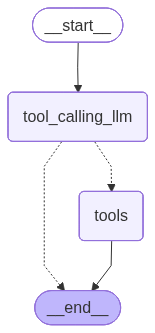

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_144bd5d0-2ae1-4113-b6bb-941a788e03f1)
 Call ID: fc_144bd5d0-2ae1-4113-b6bb-941a788e03f1
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for December 5th 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for December 5th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_3a1a55e3-ffb8-483c-8b05-e556bd6356a6)
 Call ID: fc_3a1a55e3-ffb8-483c-8b05-e556bd6356a6
  Args:
    query: AI news December 5 2025 top AI news December 5 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News & Trends December 2025: Complete Monthly Digest", "url": "https://www.humai.blog/ai-news-december-2025-monthly-digest/", "content": "OpenAI reportedly lost 6% of its user base in just one week after Google released Gemini 3, prompting the company's 'code red' response. The user exodus highlights how quickly market dynamics can shift in the competitive AI landscape.\n\n, but in moments like that – your heart sometimes skips a beat. Did 

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a sub‑field of artificial intelligence (AI) that focuses on designing algorithms and statistical models that enable computers to **learn from data**—that is, to automatically improve their performance on a specific task without being explicitly programmed for every possible scenario.

### Core Idea
- **Learning from Experience:** An ML system is given a set of examples (the *training data*) and a *goal* (e.g., predict a label, generate new content, decide an action). By analyzing patterns in the data, the system builds a model that can make predictions or decisions on new, unseen data.
- **Generalization:** The ultimate test of an ML model is its ability to generalize—perform well on data it has never encountered before.

### Main Categories

| Category | How it works | T